## Sentiment Analysis on Musical Instrument Reviews
The Amazon Musical Instrument Reviews datasets contains roughly 10,000 reviews from Amazon users for musical instruments they have bought. The key features that this dataset comes with are the review text, and the overall rating (which are star ratings between 1 and 5). 

I shall be trying to build models that can predict a user's overall rating, given the review text written by the user. I shall also be looking at sentiment analysis to train models that can classify whether a review's sentiment is positive or negative. The sentiment label for each review will be determined by the overall rating given by the user. 

In [1]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reviews = pd.read_csv("../input/amazon-music-reviews/Musical_instruments_reviews.csv")
reviews["reviewTextAndSummary"] = reviews["reviewText"] + " " + reviews["summary"]
reviews["reviewTextAndSummary"] = reviews["reviewTextAndSummary"].apply(lambda x: str(x).lower())
reviews = reviews[['reviewTextAndSummary', 'overall']]
print(reviews.shape)
reviews.head()

(10261, 2)


,reviewTextAndSummary,overall
0,"not much to write about here, but it does exac...",5.0
1,the product does exactly as it should and is q...,5.0
2,the primary job of this device is to block the...,5.0
3,nice windscreen protects my mxl mic and preven...,5.0
4,this pop filter is great. it looks and perform...,5.0


In [3]:
reviews = reviews.dropna()
reviews.shape

(10261, 2)

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewTextAndSummary  10261 non-null  object 
 1   overall               10261 non-null  float64
dtypes: float64(1), object(1)
memory usage: 240.5+ KB


# Dataset Visualisation

Star Rating Counts: 
 5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64 

Sentiment Counts: 
 1    9022
0    1239
Name: sentiment, dtype: int64


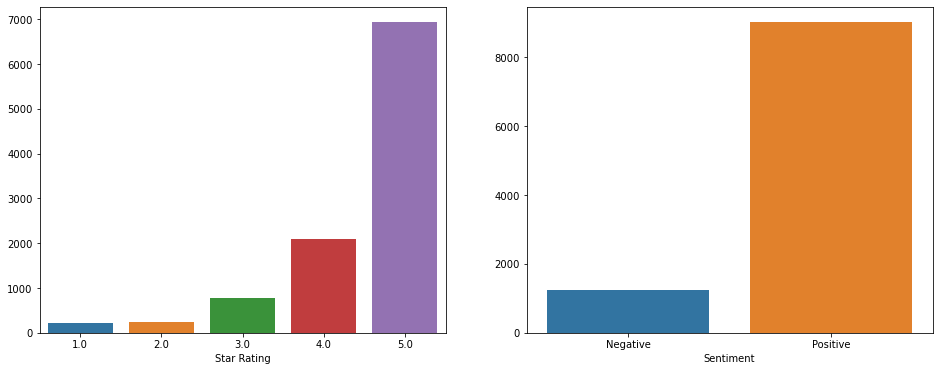

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

star_rating_counts = reviews.overall.value_counts()
reviews["sentiment"] = reviews.overall.apply(lambda x: 0 if int(x) in [1, 2, 3] else 1)
sentiment_counts = reviews.sentiment.value_counts()

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax[1])
sns.barplot(x=star_rating_counts.index, y=star_rating_counts.values, ax=ax[0])
ax[0].set_xlabel("Star Rating")
ax[1].set_xlabel("Sentiment")
ax[1].set_xticklabels(["Negative","Positive"])

print("Star Rating Counts: \n", star_rating_counts, "\n")
print("Sentiment Counts: \n", sentiment_counts)

Here we can see there are lot more positive reviews than negative ones in this dataset. Almost 90% of the reviews have an overall rating of 4 stars and above. We will see how this affects the accuracy of my models with such an imbalance towards positive review samples. 

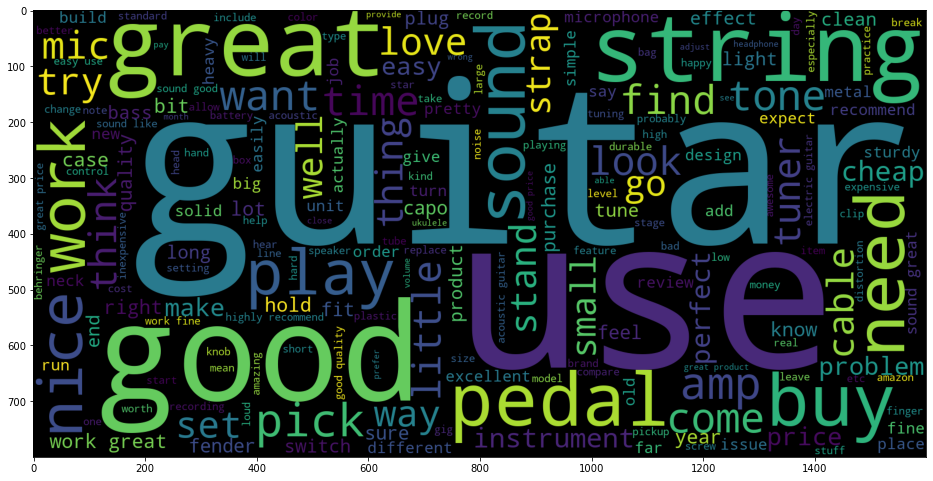

In [6]:
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_lg')

positive_sentiment = reviews.reviewTextAndSummary[reviews.sentiment == 1]
positive_word_soup = []

for text in positive_sentiment:
    doc = nlp(text)
    for token in doc:
        if (not token.is_stop and not token.is_punct and not token.like_num and token.text != " "):
            positive_word_soup.append(token.lemma_)

plt.figure(figsize=(16,16))
wc = WordCloud(width=1600, height=800).generate(" ".join(positive_word_soup))
plt.imshow(wc)

This word cloud shows the most common words that users say in positive reviews (that have a rating of 4 stars and above). This visualisation is useful when compared to the negative review word cloud shown below to see the difference in common words used to describe the review of the instrument. 

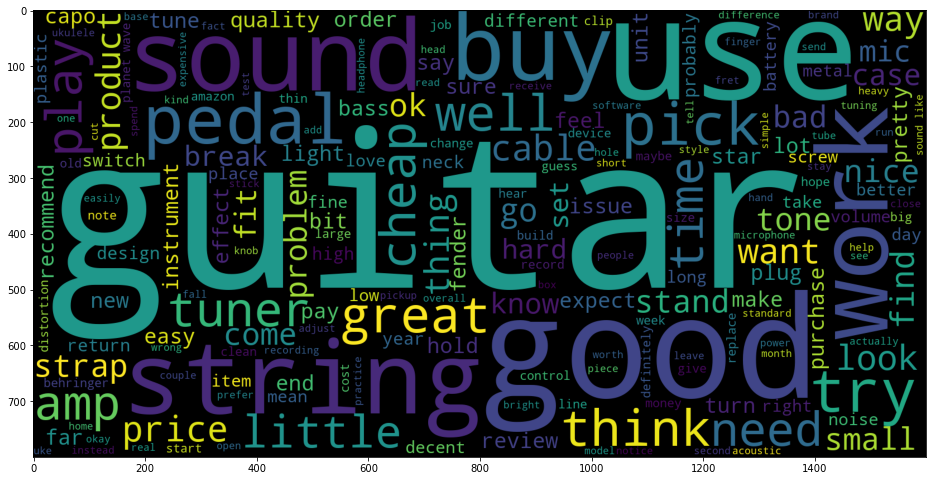

In [7]:
negative_sentiment = reviews.reviewTextAndSummary[reviews.sentiment == 0]
negative_word_soup = []

for text in negative_sentiment:
    doc = nlp(text)
    for token in doc:
        if (not token.is_stop and not token.is_punct and not token.like_num and token.text != " "):
            negative_word_soup.append(token.lemma_)

plt.figure(figsize=(16,16))
wc = WordCloud(width=1600, height=800).generate(" ".join(negative_word_soup))
plt.imshow(wc)

By comparing this word cloud to the one for positive reviews above, we can see that certain words like "sound", "string" and "work" are more common in the negative reviews. This is likely because the user's are commenting on these aspects of the instrument that they do not like. Also the words "price" and "cheap" are more common in the negative reviews, indicating that user's will more likely comment on the low price of an instrument if it is a negative review. 

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

def train_linear_models(X_train, y_train, X_test, y_test):

    params = {"penalty": ["l1", "l2", "elasticnet", "none"], "C": [1, 0.1, 0.01, 0.001]}

    logistic_model = GridSearchCV(LogisticRegression(random_state=1, max_iter=1000), params, n_jobs=-1)
    logistic_model.fit(X_train, y_train)
    print("Logistic regression best parameters: {}".format(logistic_model.best_params_))
    y_pred = logistic_model.best_estimator_.predict(X_test)
    print("Logistic regression Test Accuracy: {}\n".format(accuracy_score(y_test, y_pred)))

    params = {"C": [1, 0.1, 0.01, 0.001]}

    svc_model = GridSearchCV(LinearSVC(random_state=1, max_iter=2000), params, n_jobs=-1)
    svc_model.fit(X_train, y_train)
    print("Linear SVC best parameters: {}".format(svc_model.best_params_))
    y_pred = svc_model.best_estimator_.predict(X_test)
    print("Linear SVC Test Accuracy: {}\n".format(accuracy_score(y_test, y_pred)))

    params = {"loss": ["hinge", "log", "modified_huber"], "penalty": ["l1", "l2", "elasticnet"], "alpha": [0.1, 0.01, 0.001, 0.0001]}

    SGD_model = GridSearchCV(SGDClassifier(random_state=1), params, n_jobs=-1)
    SGD_model.fit(X_train, y_train)
    print("SGD Classifier best parameters: {}".format(SGD_model.best_params_))
    y_pred = SGD_model.best_estimator_.predict(X_test)
    print("SGD Classifier Test Accuracy: {}".format(accuracy_score(y_test, y_pred)))

In this method above, I am training three different types of linear models: Logistic Regression, Linear SVC and SGD Classifier. Any of these models may perform best depending on the data provided to train on.

# Models for Predicting Overall Star Rating (1 to 5)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews.reviewTextAndSummary, reviews.overall, test_size=0.2, random_state=1)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

print('X_train_cv: ', X_train_cv.shape)
print('X_test_cv: ', X_test_cv.shape)

X_train_cv:  (8208, 18644)
X_test_cv:  (2053, 18644)


In [11]:
print("=== Using Count Vectoriser (Bag of Words) for Star Rating Classification ===\n")
train_linear_models(X_train_cv, y_train, X_test_cv, y_test)

=== Using Count Vectoriser (Bag of Words) for Star Rating Classification ===

Logistic regression best parameters: {'C': 0.1, 'penalty': 'l2'}
Logistic regression Test Accuracy: 0.6902094495859717

Linear SVC best parameters: {'C': 0.01}
Linear SVC Test Accuracy: 0.6950803701899659

SGD Classifier best parameters: {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}
SGD Classifier Test Accuracy: 0.6838772528007794


To start with, let's look at using the CountVectoriser class from scikit-learn. This is effectively the Bag-of-Words method which forms a list of all the words (or vocabulary) found across the training reviews, then creates a vector that counts the number of occurences of each word in a training review. 

The best linear model using this method is Linear SVC with a test accuracy of 69.5%. 

We can also look at other methods of text analysis. Next we'll try TF-IDF.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(stop_words="english")
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

print('X_train_tv: ', X_train_tv.shape)
print('X_test_tv: ', X_test_tv.shape)

X_train_tv:  (8208, 18644)
X_test_tv:  (2053, 18644)


In [13]:
print("=== Using TF-IDF Vectoriser for Star Rating Classification ===\n")
train_linear_models(X_train_tv, y_train, X_test_tv, y_test)

=== Using TF-IDF Vectoriser for Star Rating Classification ===

Logistic regression best parameters: {'C': 1, 'penalty': 'l2'}
Logistic regression Test Accuracy: 0.6882610813443741

Linear SVC best parameters: {'C': 0.1}
Linear SVC Test Accuracy: 0.6819288845591817

SGD Classifier best parameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'elasticnet'}
SGD Classifier Test Accuracy: 0.6911836337067706


This time we're using the TF-IDF (Term Frequency - Inverse Document Frequency) method, which is similar to CountVectoriser except it penalises words that commonly occur across all reviews, and more heavily weighs any words that are only found in a small subset of reviews.

This time the best linear model is the SGD Classifier with a test accuracy of 69.1%

The final method of text analysis that we shall try is word embeddings (using spaCy).

In [14]:
vectors = []

for idx, review in reviews.iterrows():
    doc = nlp(review.reviewTextAndSummary)
    doc_vector = np.zeros(300)
    for token in doc:
        if (not token.is_stop and not token.is_punct and not token.like_num and token.text != " "):
            doc_vector = doc_vector + token.vector
    doc_vector = np.divide(doc_vector, len(doc))     
    vectors.append(doc_vector)
    
vectors = np.array(vectors)
print(vectors.shape)

X_train_dv, X_test_dv, y_train, y_test = train_test_split(vectors, reviews.overall, test_size=0.2, random_state=1)

(10261, 300)


In [15]:
print("=== Using spaCy Document Vectors (Word Embeddings) for Star Rating Classification ===\n")
train_linear_models(X_train_dv, y_train, X_test_dv, y_test)

=== Using spaCy Document Vectors (Word Embeddings) for Star Rating Classification ===

Logistic regression best parameters: {'C': 1, 'penalty': 'l2'}
Logistic regression Test Accuracy: 0.6760837798343887

Linear SVC best parameters: {'C': 1}
Linear SVC Test Accuracy: 0.6760837798343887

SGD Classifier best parameters: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}
SGD Classifier Test Accuracy: 0.6775450560155869


This method of using word embeddings converts every word token in a float vector of length 300. For a single review, all the vectors for every word token in a review are averaged to form a single document vector. This document vector, x, is paired with it's corresponding label y to become a training sample (x, y).

The best linear model for this method is SGD Classifier with a test accuracy of 67.8%.

All of the models performed worse than the previous two methods of text analysis, but only by a 1-2% drop.

## Conclusion for Predicting Overall Star Rating
The best model found is the Linear SVC model using the CountVectoriser method, with a test accuracy of 69.5%. This is not a very good accuracy though, and could not be suitably deployed into the real world. The predictions are not accurate enough.

# Models for Classifying the Review Sentiment (Positive/Negative)
Instead of trying to predict the star rating of each review, this time we will only look at classifying the sentiment of each review into positive and negative. To do this, we'll assume that all reviews with 3 stars and below are considered negative, and 4 or 5 star reviews are considered positive. We'll then train the same linear models with the same three methods of text analysis to compare the results.

In [16]:
y_train = y_train.apply(lambda x: 0 if int(x) in [1, 2, 3] else 1) 
y_test = y_test.apply(lambda x: 0 if int(x) in [1, 2, 3] else 1) 

In [17]:
print("=== Using Count Vectoriser (Bag of Words) for POSTIVE/NEGATIVE Sentiment Classification ===\n")
train_linear_models(X_train_cv, y_train, X_test_cv, y_test)

=== Using Count Vectoriser (Bag of Words) for POSTIVE/NEGATIVE Sentiment Classification ===

Logistic regression best parameters: {'C': 0.1, 'penalty': 'l2'}
Logistic regression Test Accuracy: 0.8952752070141257

Linear SVC best parameters: {'C': 0.01}
Linear SVC Test Accuracy: 0.8962493911349245

SGD Classifier best parameters: {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
SGD Classifier Test Accuracy: 0.8996590355577204


In [18]:
print("=== Using TF-IDF Vectoriser for POSTIVE/NEGATIVE Sentiment Classification ===\n")
train_linear_models(X_train_tv, y_train, X_test_tv, y_test)

=== Using TF-IDF Vectoriser for POSTIVE/NEGATIVE Sentiment Classification ===

Logistic regression best parameters: {'C': 1, 'penalty': 'l2'}
Logistic regression Test Accuracy: 0.8855333658061374

Linear SVC best parameters: {'C': 1}
Linear SVC Test Accuracy: 0.8986848514369216

SGD Classifier best parameters: {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}
SGD Classifier Test Accuracy: 0.9001461276181199


In [19]:
print("=== Using spaCy Document Vectors (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===\n")
train_linear_models(X_train_dv, y_train, X_test_dv, y_test)

=== Using spaCy Document Vectors (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===

Logistic regression best parameters: {'C': 1, 'penalty': 'none'}
Logistic regression Test Accuracy: 0.8894301022893327

Linear SVC best parameters: {'C': 1}
Linear SVC Test Accuracy: 0.8913784705309303

SGD Classifier best parameters: {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}
SGD Classifier Test Accuracy: 0.8869946419873356


Looking at the three sets of results above, we can see that the models are far more accurate at classifying the sentiment of each review, when compared to predicting the overall star rating. 

The best model found is the SGD Classifier using the TF-IDF method, with a test accuracy of 90%. This is much better than 69.5% accuracy for predicting star ratings, we can could more reliably use this model in deployment. 

Before concluding, I shall also try to build a neural network model to see if it can improve on 90% accuracy, once again comparing with all three text analysis methods.

In [20]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def build_model(input_shape):
    
    model = Sequential()
    model.add(Dense(units=128, activation = 'relu', input_dim=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(units=64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(units=32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(units=16, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(units=1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model = build_model(X_train_cv.shape[1])
history = model.fit(X_train_cv.todense(), y_train, batch_size=32, epochs=100, validation_data=(X_test_cv.todense(), y_test))
results = model.evaluate(X_test_cv.todense(), y_test, batch_size=256)

Epoch 1/100
257/257 [==============================] - 3s 12ms/step - loss: 0.7205 - accuracy: 0.6393 - val_loss: 0.4204 - val_accuracy: 0.8758
Epoch 2/100
257/257 [==============================] - 3s 10ms/step - loss: 0.4745 - accuracy: 0.8194 - val_loss: 0.3795 - val_accuracy: 0.8758
Epoch 3/100
257/257 [==============================] - 3s 11ms/step - loss: 0.4154 - accuracy: 0.8587 - val_loss: 0.3700 - val_accuracy: 0.8758
Epoch 4/100
257/257 [==============================] - 2s 9ms/step - loss: 0.3875 - accuracy: 0.8707 - val_loss: 0.3616 - val_accuracy: 0.8758
Epoch 5/100
257/257 [==============================] - 2s 9ms/step - loss: 0.3628 - accuracy: 0.8741 - val_loss: 0.3484 - val_accuracy: 0.8758
Epoch 6/100
257/257 [==============================] - 2s 9ms/step - loss: 0.3230 - accuracy: 0.8827 - val_loss: 0.3430 - val_accuracy: 0.8768
Epoch 7/100
257/257 [==============================] - 3s 10ms/step - loss: 0.2884 - accuracy: 0.8918 - val_loss: 0.3337 - val_accuracy: 0.

Epoch 58/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 0.9783 - val_accuracy: 0.8933
Epoch 59/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0417 - accuracy: 0.9893 - val_loss: 0.9221 - val_accuracy: 0.8919
Epoch 60/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0381 - accuracy: 0.9899 - val_loss: 0.9227 - val_accuracy: 0.8933
Epoch 61/100
257/257 [==============================] - 2s 10ms/step - loss: 0.0433 - accuracy: 0.9892 - val_loss: 0.8835 - val_accuracy: 0.8962
Epoch 62/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0372 - accuracy: 0.9884 - val_loss: 0.9161 - val_accuracy: 0.8948
Epoch 63/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0384 - accuracy: 0.9899 - val_loss: 0.9560 - val_accuracy: 0.8933
Epoch 64/100
257/257 [==============================] - 2s 10ms/step - loss: 0.0305 - accuracy: 0.9929 - val_loss: 1.0149 - val_accurac

In [22]:
print("=== Using CountVectoriser (Bag of Words) for POSTIVE/NEGATIVE Sentiment Classification ===")
print("Neural Network - Final test accuracy: {0:.4f} ({1:.2f}%)".format(results[1], results[1]*100))

=== Using CountVectoriser (Bag of Words) for POSTIVE/NEGATIVE Sentiment Classification ===
Neural Network - Final test accuracy: 0.8899 (88.99%)


In [23]:
model = build_model(X_train_tv.shape[1])
history = model.fit(X_train_tv.todense(), y_train, batch_size=32, epochs=100, validation_data=(X_test_tv.todense(), y_test))
results = model.evaluate(X_test_tv.todense(), y_test, batch_size=256)

Epoch 1/100
257/257 [==============================] - 2s 9ms/step - loss: 0.7167 - accuracy: 0.6473 - val_loss: 0.4188 - val_accuracy: 0.8758
Epoch 2/100
257/257 [==============================] - 2s 8ms/step - loss: 0.4803 - accuracy: 0.8151 - val_loss: 0.3754 - val_accuracy: 0.8758
Epoch 3/100
257/257 [==============================] - 2s 8ms/step - loss: 0.4163 - accuracy: 0.8598 - val_loss: 0.3670 - val_accuracy: 0.8758
Epoch 4/100
257/257 [==============================] - 2s 8ms/step - loss: 0.3935 - accuracy: 0.8728 - val_loss: 0.3619 - val_accuracy: 0.8758
Epoch 5/100
257/257 [==============================] - 2s 8ms/step - loss: 0.3636 - accuracy: 0.8771 - val_loss: 0.3535 - val_accuracy: 0.8763
Epoch 6/100
257/257 [==============================] - 2s 8ms/step - loss: 0.3180 - accuracy: 0.8835 - val_loss: 0.3432 - val_accuracy: 0.8768
Epoch 7/100
257/257 [==============================] - 2s 8ms/step - loss: 0.2698 - accuracy: 0.8936 - val_loss: 0.3678 - val_accuracy: 0.8811

Epoch 58/100
257/257 [==============================] - 2s 7ms/step - loss: 0.0334 - accuracy: 0.9915 - val_loss: 1.0076 - val_accuracy: 0.8938
Epoch 59/100
257/257 [==============================] - 2s 8ms/step - loss: 0.0268 - accuracy: 0.9927 - val_loss: 1.0638 - val_accuracy: 0.8904
Epoch 60/100
257/257 [==============================] - 2s 8ms/step - loss: 0.0307 - accuracy: 0.9916 - val_loss: 1.0188 - val_accuracy: 0.8919
Epoch 61/100
257/257 [==============================] - 2s 8ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 1.0198 - val_accuracy: 0.8875
Epoch 62/100
257/257 [==============================] - 2s 9ms/step - loss: 0.0186 - accuracy: 0.9948 - val_loss: 1.0439 - val_accuracy: 0.8885
Epoch 63/100
257/257 [==============================] - 2s 8ms/step - loss: 0.0251 - accuracy: 0.9935 - val_loss: 1.1005 - val_accuracy: 0.8899
Epoch 64/100
257/257 [==============================] - 2s 7ms/step - loss: 0.0262 - accuracy: 0.9934 - val_loss: 0.9776 - val_accuracy:

In [24]:
print(" Using TF-IDF Vectoriser (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===")
print("Neural Network - Final test accuracy: {0:.4f} ({1:.2f}%)".format(results[1], results[1]*100))

 Using TF-IDF Vectoriser (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===
Neural Network - Final test accuracy: 0.8924 (89.24%)


In [25]:
model = build_model(X_train_dv.shape[1])
history = model.fit(X_train_dv, y_train, batch_size=32, epochs=100, validation_data=(X_test_dv, y_test))
results = model.evaluate(X_test_dv, y_test, batch_size=256)

Epoch 1/100
257/257 [==============================] - 2s 7ms/step - loss: 0.7254 - accuracy: 0.6510 - val_loss: 0.4144 - val_accuracy: 0.8758
Epoch 2/100
257/257 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.8068 - val_loss: 0.3543 - val_accuracy: 0.8758
Epoch 3/100
257/257 [==============================] - 1s 6ms/step - loss: 0.3998 - accuracy: 0.8533 - val_loss: 0.3425 - val_accuracy: 0.8758
Epoch 4/100
257/257 [==============================] - 2s 6ms/step - loss: 0.3827 - accuracy: 0.8684 - val_loss: 0.3360 - val_accuracy: 0.8758
Epoch 5/100
257/257 [==============================] - 2s 7ms/step - loss: 0.3473 - accuracy: 0.8744 - val_loss: 0.3205 - val_accuracy: 0.8758
Epoch 6/100
257/257 [==============================] - 1s 6ms/step - loss: 0.3418 - accuracy: 0.8756 - val_loss: 0.3150 - val_accuracy: 0.8758
Epoch 7/100
257/257 [==============================] - 1s 6ms/step - loss: 0.3367 - accuracy: 0.8757 - val_loss: 0.3042 - val_accuracy: 0.8777

Epoch 58/100
257/257 [==============================] - 2s 6ms/step - loss: 0.2456 - accuracy: 0.8992 - val_loss: 0.2867 - val_accuracy: 0.8924
Epoch 59/100
257/257 [==============================] - 2s 6ms/step - loss: 0.2446 - accuracy: 0.8947 - val_loss: 0.2852 - val_accuracy: 0.8948
Epoch 60/100
257/257 [==============================] - 2s 6ms/step - loss: 0.2444 - accuracy: 0.8962 - val_loss: 0.2904 - val_accuracy: 0.8924
Epoch 61/100
257/257 [==============================] - 2s 8ms/step - loss: 0.2530 - accuracy: 0.8955 - val_loss: 0.2853 - val_accuracy: 0.8953
Epoch 62/100
257/257 [==============================] - 2s 6ms/step - loss: 0.2430 - accuracy: 0.8953 - val_loss: 0.2916 - val_accuracy: 0.8924
Epoch 63/100
257/257 [==============================] - 1s 6ms/step - loss: 0.2448 - accuracy: 0.8952 - val_loss: 0.2949 - val_accuracy: 0.8914
Epoch 64/100
257/257 [==============================] - 1s 6ms/step - loss: 0.2417 - accuracy: 0.8962 - val_loss: 0.2861 - val_accuracy:

In [26]:
print("=== Using spaCy Document Vectors (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===")
print("Neural Network - Final test accuracy: {0:.4f} ({1:.2f}%)".format(results[1], results[1]*100))

=== Using spaCy Document Vectors (Word Embeddings) for POSTIVE/NEGATIVE Sentiment Classification ===
Neural Network - Final test accuracy: 0.8928 (89.28%)


The best neural network model achieved has a test accuracy of 89.28%, when using the word embeddings method. The best linear model was the SGD Classifier using the TF-IDF method, with a test accuracy of 90%. This means that the neural network models have not beaten the best test accuracy of 90% from the linear models. 

## Conclusion for Classifying the Review Sentiment
In conclusion, the best model for classifiyng the sentiment of reviews into positive/negative is the SGD Classifier using the TF-IDF method, with a test accuracy of 90%. This is a big improvement on the accuracy for predicting overall star rating.

Further things to try in the future are changing the sentiment labels from Positive/Negative to Positive/Neutral/Negative to see how it affects the accuracy of the models. It may also be useful to obtain more low-rated reviews with a negative sentiment, so that my models do not overfit towards positive reviews so much. 